In [223]:
from utils.database_connection import DatabaseConnection
import utils.results_repository as rep
import pandas as pd
import numpy as np
from utils.column_name_utils import *
import utils.query_utils as query
import matplotlib.pyplot as plot
import utils.dataframe_utils as df_util
import utils.path_utils as path_util

In [224]:
db = DatabaseConnection()

Connected to MySQL Server version  8.0.31-23


In [225]:
measurements_used = 25
energy_per_time = 1000

In [226]:
experiment_name = "same-cpp-multi-core-micro-benchmark-different-compiler"
experiment_number = 1

used_dut_name = [
    'workstationone'
]

used_dut_name.sort()

used_dut_env = 'prod'

used_test_case_names = [
    'fannkuch-redux.exe',
    'mandelbrot.exe'
]

used_test_case_names.sort()

used_compilers = [
    'clang'
]

used_compilers.sort()

used_thread = [
    'multi-threaded'
]

used_thread.sort()

used_test_case_name = 'idle-case.exe'

ipg = "ipg"
lhm = "lhm"

used_mi_names = [
    lhm, ipg
]

used_mi_names.sort()

ipg_sample_rate = 333
lhm_sample_rate = 100

used_min_temp = 0
used_max_temp = 200
used_burn_in = 1
used_allocated_cores = [
    []
]

used_allocated_cores.sort()

### DUTs

In [227]:
used_dut_name_str = "','".join(used_dut_name)

In [228]:
dut = rep.get_devices_under_test(db)

dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [229]:
used_dut = dut.query(f"{ENV} == '{used_dut_env}' and {NAME} in ('{used_dut_name_str}')")

### Test Cases

In [230]:
tc = rep.get_test_cases(db)

tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded
3,4,fannkuch-redux.exe,intel-one-api,c++,-openmp,microbenchmarks,12,multi-threaded
4,5,mandelbrot.exe,intel-one-api,c++,-openmp,microbenchmarks,16000,multi-threaded
5,6,idle-case.exe,intel-one-api,c++,-openmp,microbenchmarks,,multi-threaded
6,7,fannkuch-redux.exe,min-gw,c++,-openmp,microbenchmarks,12,multi-threaded
7,8,mandelbrot.exe,min-gw,c++,-openmp,microbenchmarks,16000,multi-threaded
8,9,idle-case.exe,min-gw,c++,-openmp,microbenchmarks,,multi-threaded
9,10,fannkuch-redux.exe,msvc,c++,-openmp,microbenchmarks,12,multi-threaded


In [231]:
used_test_case_name_str = "','".join(used_test_case_names)
used_compiler_str = "','".join(used_compilers)
used_thread_str = "','".join(used_thread)

used_tc = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} in ('{used_test_case_name_str}') and {THREADS} in ('{used_thread_str}')")

In [232]:
used_idle_case = tc.query(f"{COMPILER} in ('{used_compiler_str}') and {NAME} == '{used_test_case_name}' and {THREADS} in ('{used_thread_str}')")

### Measuring Instruments

In [233]:
mi = rep.get_measuring_instruments(db)

mi

,Id,Name,SampleRate
0,1,lhm,100
1,2,ipg,333
2,3,ipg,250


In [234]:
used_mi = mi.query(f"({NAME} == '{ipg}' and {SAMPLE_RATE} == {ipg_sample_rate}) or ({NAME} == '{lhm}' and {SAMPLE_RATE} == {lhm_sample_rate})")

### Configurations

In [235]:
used_allocated_cores_str = "','".join([str(x) for x in used_allocated_cores])

In [236]:
config = rep.get_configurations(db)

config

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [237]:
used_configs = config.query(f"{MIN_TEMP} == {used_min_temp} and " +
                            f"{MAX_TEMP} == {used_max_temp} and " +
                            f"{BURN_IN} == {used_burn_in} and " +
                            f"{ALLOCATED_CORES} in ('{used_allocated_cores_str}')")

### Experiment Names

In [238]:
exp = rep.get_distinct_experiments(db)

exp

,Experiment,Name
0,1,same-cpp-multi-core-micro-benchmark-different-...


## Used Things

In [239]:
used_dut

,Id,Name,Os,Env
0,1,workstationone,win32nt,prod


In [240]:
used_tc

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
0,1,fannkuch-redux.exe,clang,c++,-openmp,microbenchmarks,12,multi-threaded
1,2,mandelbrot.exe,clang,c++,-openmp,microbenchmarks,16000,multi-threaded


In [241]:
used_mi

,Id,Name,SampleRate
0,1,lhm,100
1,2,ipg,333


In [242]:
used_idle_case

,Id,Name,Compiler,Language,Optimizations,TestCaseSize,Parameter,Threads
2,3,idle-case.exe,clang,c++,-openmp,microbenchmarks,,multi-threaded


In [243]:
used_configs

,Id,MinTemp,MaxTemp,Burnin,AllocatedCores
0,1,0,200,1,[]


In [244]:
cpu_energy_results = {}
dram_energy_results = {}
gpu_energy_results = {}
duration_results = {}

cpu_dynamic_energy_consumption = {}
gpu_dynamic_energy_consumption = {}
dram_dynamic_energy_consumption = {}

for dut_index, dut_row in used_dut.iterrows():
    dut_id = dut_row[ID]
    dut_name = dut_row[NAME]
    for mi_index, mi_row in used_mi.iterrows():
        mi_id = mi_row[ID]
        mi_name = mi_row[NAME]
        for config_index, config_row in used_configs.iterrows():
            config_id = config_row[ID]
            config_cores = config_row[ALLOCATED_CORES]
            for tc_index, tc_row in used_tc.iterrows():
                tc_id = tc_row[ID]
                tc_name = tc_row[NAME]
                tc_compiler = tc_row[COMPILER]
                tc_language = tc_row[LANGUAGE]
                tc_optimizations = tc_row[OPTIMIZATIONS]
                tc_test_case_size = tc_row[TEST_CASE_SIZE]
                tc_threads = tc_row[THREADS]
                
                tc_idle_case = query.get_idle_case(used_idle_case, tc_compiler, tc_language, tc_optimizations, tc_test_case_size, tc_threads)
                tc_idle_case_id =int(tc_idle_case[ID].iloc[0])
                
                tc_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_id, experiment_name, experiment_number)
                tc_idle_case_collection = rep.get_collections(db, dut_id, mi_id, config_id, tc_idle_case_id, experiment_name, experiment_number)
                
                tc_collection_id = int(tc_collection[ID].iloc[0])
                tc_idle_case_collection_id = int(tc_idle_case_collection[ID].iloc[0])
                
                tc_measurements = rep.get_measurements(db, tc_collection_id)
                tc_idle_case_measurements = rep.get_measurements(db, tc_idle_case_collection_id)
                
                key = f"{tc_name}.{mi_name}.{dut_name}.{config_cores}"
                
                dram_energy_results[key] = list(tc_measurements["DramEnergyInJoules"])
                cpu_energy_results[key] = list(tc_measurements["CpuEnergyInJoules"])
                gpu_energy_results[key] = list(tc_measurements["GpuEnergyInJoules"])
                duration_results[key] = list(tc_measurements["Duration"])
                
                idle_cpu_consumption = df_util.get_cpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_gpu_consumption = df_util.get_gpu_energy_per_time(tc_idle_case_measurements, energy_per_time)
                idle_dram_consumption = df_util.get_dram_energy_per_time(tc_idle_case_measurements, energy_per_time)
                
                cpu_dynamic_energy_consumption[key] = df_util.get_cpu_dynamic_energy(tc_measurements, idle_cpu_consumption, energy_per_time)
                gpu_dynamic_energy_consumption[key] = df_util.get_gpu_dynamic_energy(tc_measurements, idle_gpu_consumption, energy_per_time)
                dram_dynamic_energy_consumption[key] = df_util.get_dram_dynamic_energy(tc_measurements, idle_dram_consumption, energy_per_time)

In [245]:
for key, value in dram_energy_results.items():
    dram_energy_results[key] = value[:measurements_used]
    
for key, value in cpu_energy_results.items():
    cpu_energy_results[key] = value[:measurements_used]

for key, value in gpu_energy_results.items():
    gpu_energy_results[key] = value[:measurements_used]

for key, value in duration_results.items():
    duration_results[key] = value[:measurements_used]
    
for key, value in cpu_dynamic_energy_consumption.items():
    cpu_dynamic_energy_consumption[key] = value[:measurements_used]

for key, value in gpu_dynamic_energy_consumption.items():
    gpu_dynamic_energy_consumption[key] = value[:measurements_used]
    
for key, value in dram_dynamic_energy_consumption.items():
    dram_dynamic_energy_consumption[key] = value[:measurements_used]

In [246]:
## Energy consumption for the entire test case
dram_df = pd.DataFrame(dram_energy_results)
dram_df =dram_df.reindex(columns=sorted(dram_df.columns))

cpu_df = pd.DataFrame(cpu_energy_results)
cpu_df = cpu_df.reindex(columns=sorted(cpu_df.columns))

gpu_df = pd.DataFrame(gpu_energy_results)
gpu_df = gpu_df.reindex(columns=sorted(gpu_df.columns))

duration_df = pd.DataFrame(duration_results)
duration_df = duration_df.reindex(columns=sorted(duration_df.columns))

## Dynamic energy data frames
dram_dynamic_df = pd.DataFrame(dram_dynamic_energy_consumption)
dram_dynamic_df = dram_dynamic_df.reindex(columns=sorted(duration_df.columns))

cpu_dynamic_df = pd.DataFrame(cpu_dynamic_energy_consumption)
cpu_dynamic_df = cpu_dynamic_df.reindex(columns=sorted(cpu_dynamic_df.columns))

gpu_dynamic_df = pd.DataFrame(gpu_dynamic_energy_consumption)
gpu_dynamic_df = gpu_dynamic_df.reindex(columns=sorted(gpu_dynamic_df.columns))

Combined DRAM Energy Consumption in Joules


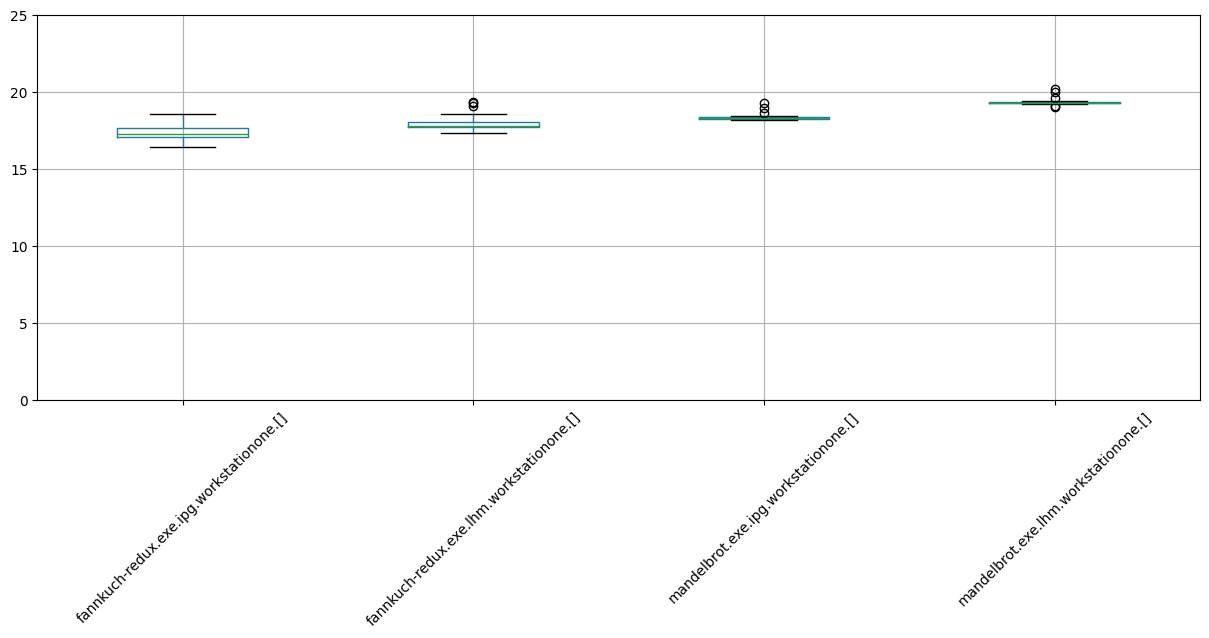

Combined CPU Energy Consumption in Joules


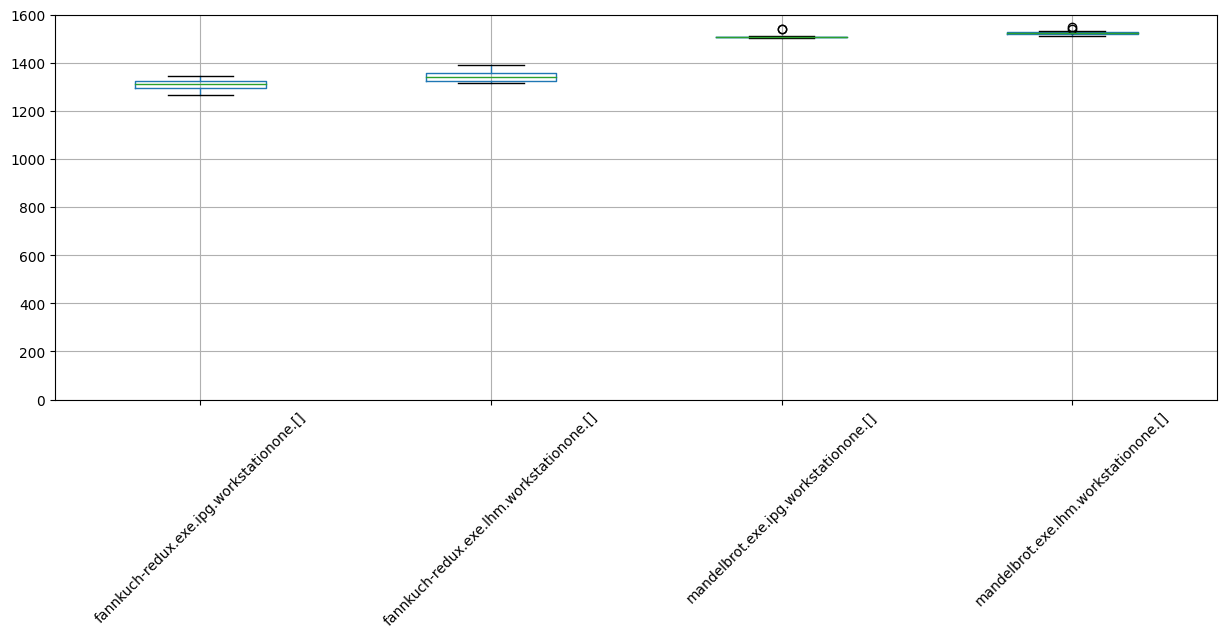

Combined GPU Energy Consumption in Joules


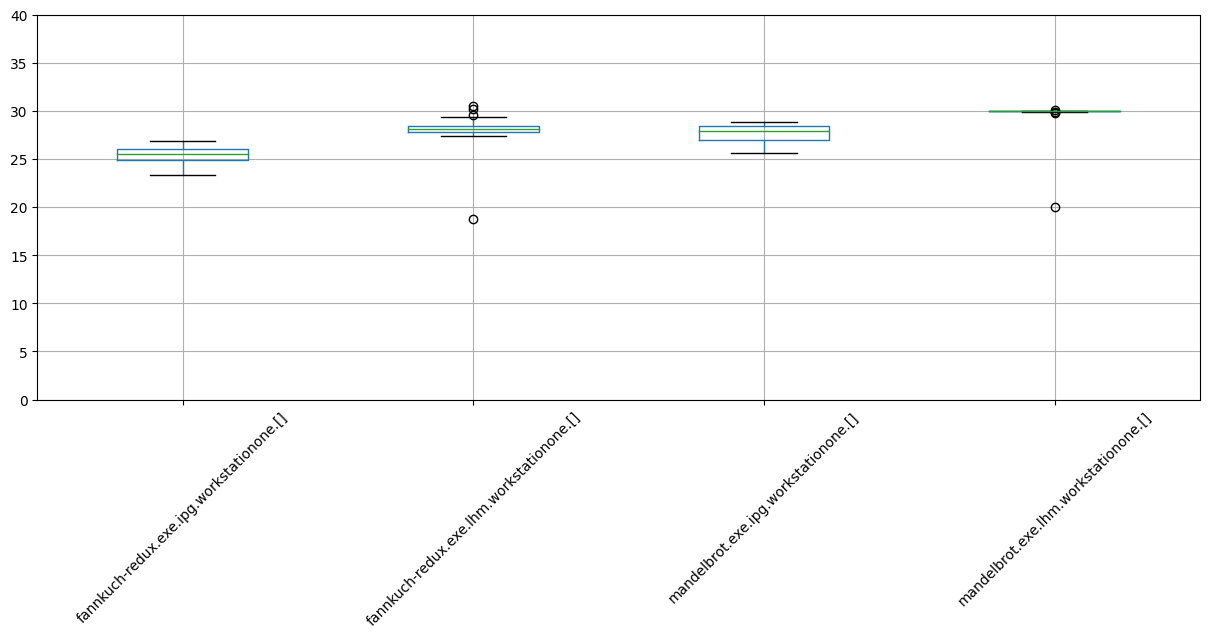

Duration of Test Case


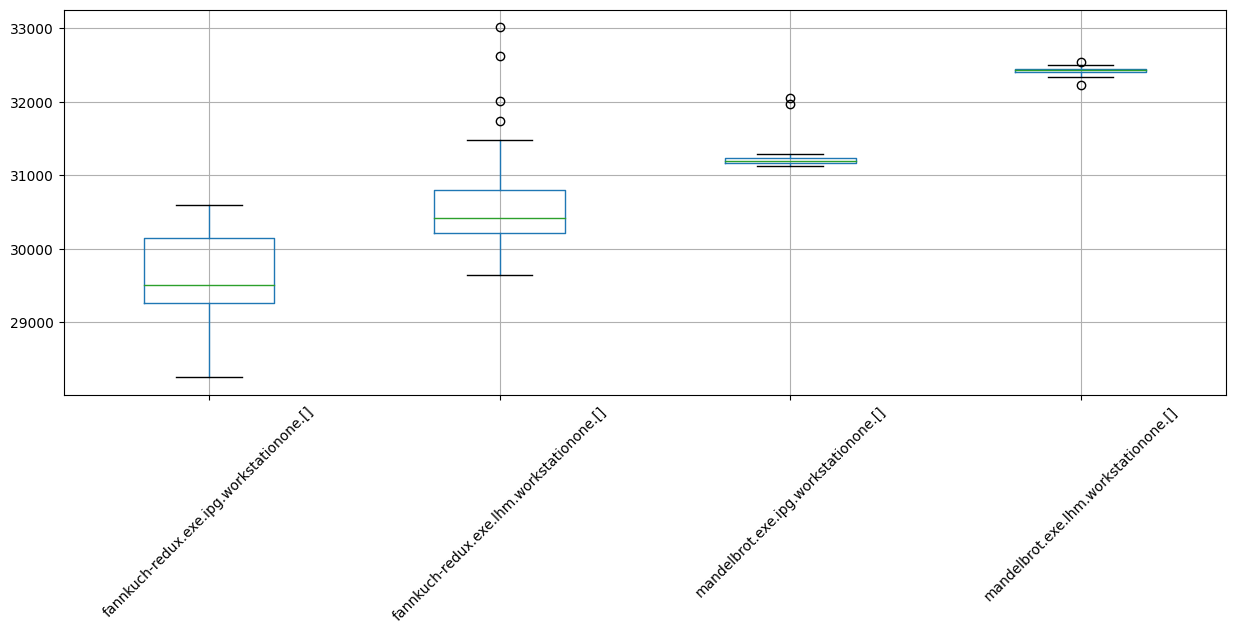

In [247]:
print("Combined DRAM Energy Consumption in Joules")
dram_boxplot = dram_df.boxplot(figsize=(15,5), rot=45)
dram_boxplot.plot()
plot.ylim(0, 25)
plot.show()

print("Combined CPU Energy Consumption in Joules")
cpu_boxplot = cpu_df.boxplot(figsize=(15,5), rot=45)
cpu_boxplot.plot()
cpu_boxplot
plot.ylim(0,1600)
plot.show()

print("Combined GPU Energy Consumption in Joules")
gpu_boxplot = gpu_df.boxplot(figsize=(15,5), rot=45)
gpu_boxplot.plot()
plot.ylim(0,40)
plot.show()

print("Duration of Test Case")
duration_boxplot = duration_df.boxplot(figsize=(15,5), rot=45)
duration_boxplot.plot()
# plot.ylim(0,40)
plot.show()

Dynamic DRAM Energy Consumption in Watts


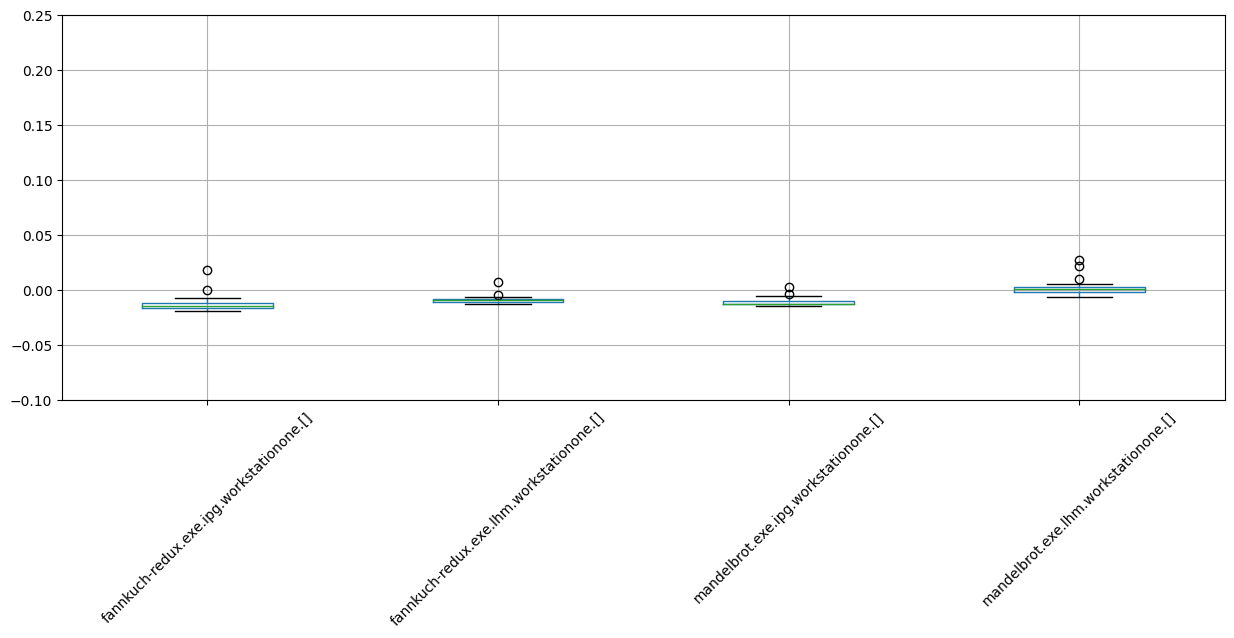

Dynamic CPU Energy Consumption in Watts


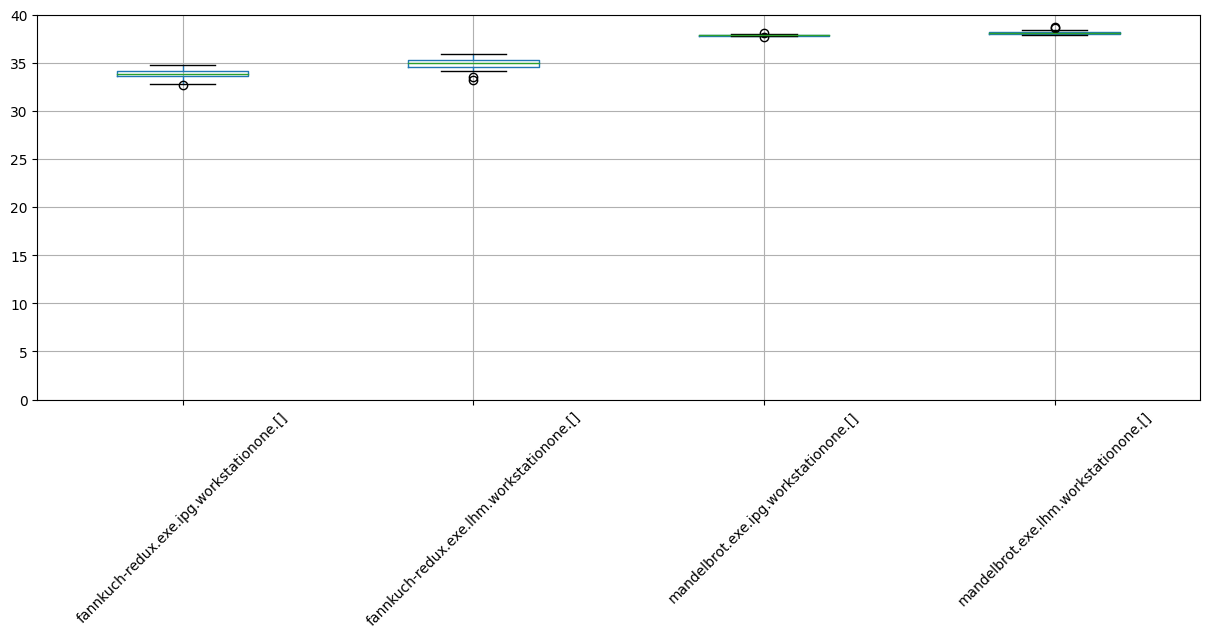

Dynamic GPU Energy Consumption in Watts


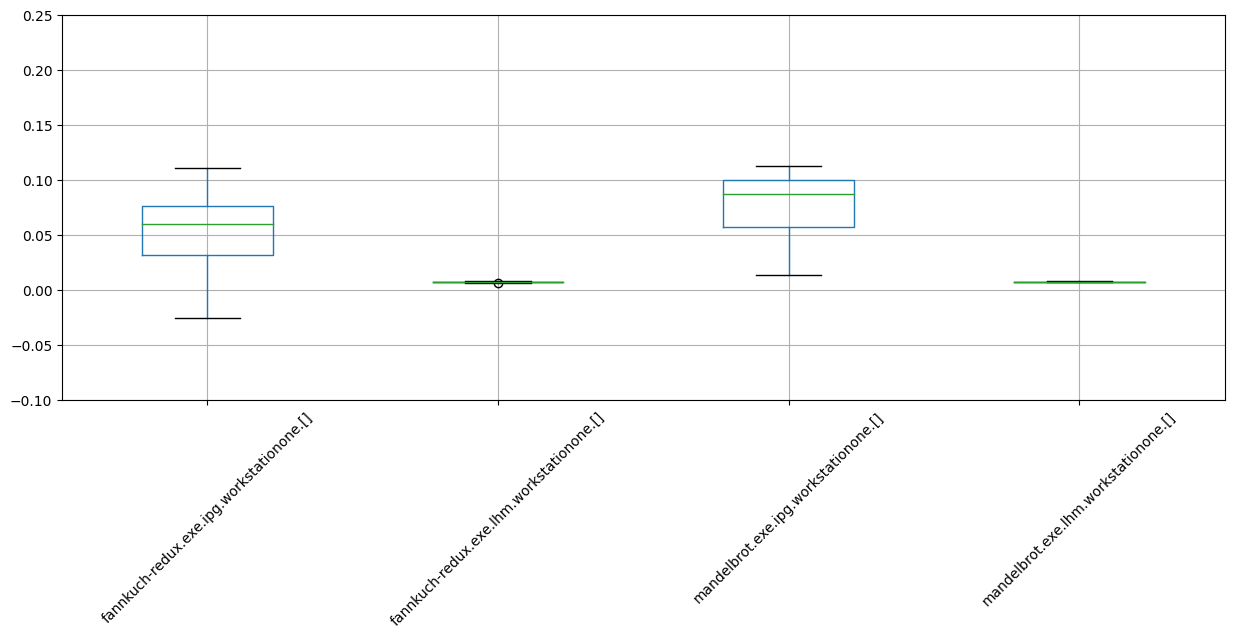

In [248]:
print("Dynamic DRAM Energy Consumption in Watts")
dynamic_dram_boxplot = dram_dynamic_df.boxplot(figsize=(15,5), rot=45)
dynamic_dram_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()

print("Dynamic CPU Energy Consumption in Watts")
dynamic_cpu_boxplot = cpu_dynamic_df.boxplot(figsize=(15,5), rot=45)
dynamic_cpu_boxplot.plot()
plot.ylim(0,40)
plot.show()

print("Dynamic GPU Energy Consumption in Watts")
dynamic_gpu_boxplot = gpu_dynamic_df.boxplot(figsize=(15,5), rot=45)
dynamic_gpu_boxplot.plot()
plot.ylim(-0.1, 0.25)
plot.show()


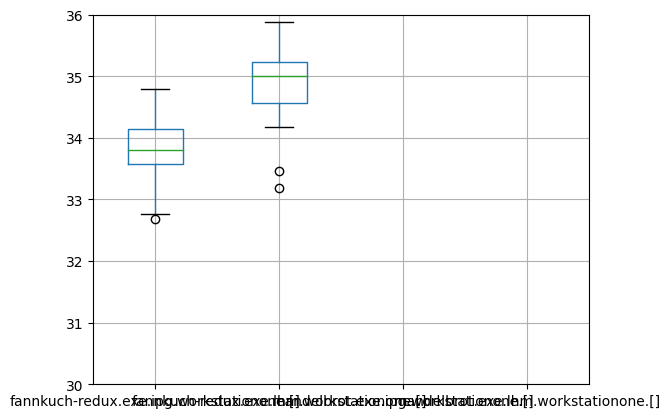

In [249]:
dynamic_cpu_boxplot_test, cpu_dynamic_boxplot_data = cpu_dynamic_df.boxplot(return_type='both')
dynamic_cpu_boxplot_test.plot()
plot.ylim(30,36)
plot.show()

In [265]:
def get_box_template(lw, lq, m, uq, uw, c, co):
    return """
        \\addplot+ [boxplot prepared={{
                lower whisker={0},
                lower quartile={1},
                median={2},
                upper quartile={3},
                upper whisker={4}
                }}, color = {5}
                ] coordinates{{{6}}};
        """.format(lw, lq, m, uq, uw, c, co)

def get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, box_plots, caption, labels):
    return """\\begin{{figure}}
    \\centering
    \\begin{{tikzpicture}}[]
        \\pgfplotsset{{
            width={0}\\textwidth,
            height={1}\\textheight
        }}
        \\begin{{axis}}[
            xlabel={{{2}}}, 
            title={{{3}}}, 
            ytick={{{4}}},
        yticklabels={{
            {5}
            }},
            xmin={6},xmax={7},
            ]
        
        {8}
        
        \\end{{axis}}
    \\end{{tikzpicture}}
\\caption{{{9}}} \label{{fig:{10}}}
\\end{{figure}}""".format(width, height, xlabel, title, ytick, yticklables, xmin, xmax, box_plots, caption, labels)

In [251]:
def parse_outliers(outliers, i):
    parsed_input = ""
    
    for o in outliers:
        parsed_input += f"({i},{o})"
    
    return parsed_input

def parse_boxes(boxes):
    lower_quartile = boxes[0]
    upper_quartile = boxes[2]
    
    return lower_quartile, upper_quartile

def parse_whiskers(w1, w2):
    return w1[1], w2[1]

def parse_median(median):
    return median [0]

In [252]:
box_plot_raw_data = [
    {
        "data" : cpu_dynamic_df,
        "name" : "cpu",
        "data_type" : "dynamic  energy"
    }
]

In [269]:
width = 1
height = 0.5
xmin = 0
xmax = 40
xlabel = "Averate Energy Consumption (Watt)"

In [254]:
def list_to_label(lst):
    if len(lst) == 1:
        return lst[0]
    elif len(lst) == 2:
        return f"{lst[0]} and {lst[1]}"
    else:
        return ", ".join(lst[:-1]) + f" and {lst[-1]}"

In [255]:
str(list(range(2))).replace('[', '').replace(']', '')

'0, 1'

In [275]:
for plot_data in box_plot_raw_data:
    data = plot_data["data"]
    name = plot_data["name"]
    data_type = plot_data["data_type"]
    
    _, box_plot_data = data.boxplot(return_type='both')
    
    outliers = [flier.get_ydata() for flier in box_plot_data["fliers"]]
    boxes = [box.get_ydata() for box in box_plot_data["boxes"]]
    medians = [median.get_ydata() for median in box_plot_data["medians"]]
    whiskers = [whiskers.get_ydata() for whiskers in box_plot_data["whiskers"]]
    
    latex_boxes = ""
    for d in zip(outliers, boxes, medians, range(len(outliers))):
        o = d[0]
        b = d[1]
        m = d[2]
        i = d[3]
        
        w1 = whiskers[i * 2]
        w2 = whiskers[(i * 2) + 1]
        
        out = parse_outliers(o, i)
        lq, uq = parse_boxes(b)
        lw, uw = parse_whiskers(w1, w2)
        me = parse_median(m)
        col = "red"
        latex_boxes += get_box_template(lw, lq, me, uq, uw, col, out)
    
    title = f"The {data_type} consumption of the {name}"
    
    ytick = str(list(range(len(list(data.columns))))).replace('[', '').replace(']', '')
    
    yticklables = []
    
    for l in data.columns:
        column_data = l.split('.')
        l_test_case = column_data[0]
        l_measuring_instrument = column_data[2]
        l_dut_name = column_data[3] 
        l_allocated_cores = column_data[4]
        
        if len(l_allocated_cores) == 2:
            l_allocated_cores = "all"
        
        yticklables.append(f"{l_test_case} - {l_measuring_instrument} - {l_dut_name} - {l_allocated_cores} cores")
        yticklables[-1].replace("'", "")
    
    labels = f"{experiment_number}-{experiment_name}-{'-'.join(used_mi_names)}-{'-'.join(used_test_case_names)}-{'-'.join(used_compilers)}-{'-'.join(used_dut_name)}"
    
    
    c_test_cases = list_to_label(used_test_case_names)
    c_compiler = list_to_label(used_compilers)
    c_duts = list_to_label(used_dut_name)
    c_measuring_instrument = list_to_label(used_mi_names)
    
    c_test_cases = c_test_cases.replace(".exe", "")
    
    caption = f"{data_type} measurements on the {name}, measured by {c_measuring_instrument} on {c_duts}, for test cases {c_test_cases} compiled on {c_compiler}"
    
    latex_box_plot = get_boxplot_template(width, height, xlabel, title, ytick, yticklables, xmin, xmax, latex_boxes, caption, labels)

box_plot_path = f"{experiment_number}/{experiment_name}/{'-'.join(used_mi_names)}/{'-'.join(used_test_case_names)}/{'-'.join(used_dut_name)}/{'-'.join(used_compilers)}"
box_plot_file_name = f"file.tex"

path_util.write_to_path(box_plot_path, box_plot_file_name, latex_box_plot)

In [274]:
len(l_allocated_cores)

2

In [ ]:
used_mi_names

In [ ]:
cpu_dynamic_df

,fannkuch-redux.exe.ipg.workstationone.[],fannkuch-redux.exe.lhm.workstationone.[],mandelbrot.exe.ipg.workstationone.[],mandelbrot.exe.lhm.workstationone.[]
0,33.250701,35.335123,37.449913,38.646489
1,33.794635,35.599181,37.536083,38.244744
2,34.097088,35.598978,37.700407,38.075326
3,34.436375,35.100818,37.441934,38.191824
4,33.221116,35.184549,37.537134,38.277735
5,33.432714,34.325376,37.567626,38.139864
6,33.453261,33.183222,37.510721,38.155482
7,32.326605,35.885446,37.505439,38.091536
8,33.672731,35.230682,37.474447,38.020191
9,33.610581,34.833982,37.565788,37.963149


In [ ]:
outliers

[array([32.32660478761633], dtype=object),
 array([33.18322223517005, 33.463560079692016], dtype=object),
 array([37.260551764183184, 37.70040683378071], dtype=object),
 array([38.646488926165105, 38.7370082975811], dtype=object)]

In [ ]:
boxes

[array([33.22111607, 33.22111607, 33.79463491, 33.79463491, 33.22111607]),
 array([34.55935298, 34.55935298, 35.23068248, 35.23068248, 34.55935298]),
 array([37.44867016, 37.44867016, 37.53713377, 37.53713377, 37.44867016]),
 array([38.02019106, 38.02019106, 38.17944854, 38.17944854, 38.02019106])]

In [ ]:
medians

[array([33.45560167, 33.45560167]),
 array([34.99890034, 34.99890034]),
 array([37.49300008, 37.49300008]),
 array([38.08289984, 38.08289984])]

In [ ]:
whiskers

[array([33.22111607, 32.40386537]),
 array([33.79463491, 34.43637506]),
 array([34.55935298, 34.18032145]),
 array([35.23068248, 35.8854465 ]),
 array([37.44867016, 37.41779329]),
 array([37.53713377, 37.60503723]),
 array([38.02019106, 37.91064664]),
 array([38.17944854, 38.34904589])]

In [ ]:
path_util.write_to_path("yeet/yoot", "succ.tex", "YE")

```latex
\begin{figure}
    \centering
    \begin{tikzpicture}[]
        \pgfplotsset{
            width=WIDTH\textwidth, %% 0.8
            height=WIDHT\textheight %% 0.14
        }
        \begin{axis}[
            xlabel={XLABEL}, 
            title={TITLE}, 
            ytick={YTICK}, %% 1,2
        yticklabels={
            LABELS %% L1, L2, 
            },
            xmin=XMIN,xmax=XMAX,
            ]
        
        \addplot+ [boxplot prepared={
        lower whisker=LOW_WHISKER,
        lower quartile=LOW_QUANTILE,
        median=MEDIAN,
        upper quartile=UPPER_QUANTILE,
        upper whisker=UPPER_WHISKER
        }, color = red
        ] coordinates{COORDINATES}; %% (0,4.832228)(0,5.513942)
        
        \end{axis}
    \end{tikzpicture}
\caption{CAPTION} \label{fig:LABEL}
\end{figure}
```